# ⚡ Load a trained model and perform prediction and evaluation ⚡

This notebook shows how to load a pretrained LP model and perform prediction and evalutaion on the testiong data. Here, we run test on Han's bottom-view project.  

* [Load the pretrained model](#Load-the-pretrained-model)
* [Predictions for labeled data and example video](#Make-prediction-on-the-labeled-images-and-testing-videos)
<!-- * [Predictions for example video](#Make-prediction-on-the-labeled-images-and-testing-videos) -->
<!-- * [Display the short labeled video](#Display-the-short-labeled-video) -->
<!-- * [Run prediction and evaluation on labeled and video data](#Perform-prediction-and-evaluation) -->
* [Visualize keypoints: ground truth v.s. predictions](#Visualize-keypoints)
* [Video predictions and evaluation](#Plot-video-predictions-and-unsupervised-losses)
* [Perform comparison between two models](#Perform-comparison-between-two-models)

Reference for this notebook at [here](https://github.com/danbider/lightning-pose/blob/7da5b5e701cb315ffd6d3ac8847191ee6715c46e/scripts/litpose_training_demo.ipynb)


<!-- Model output directory structure . -->
**After training and testing, a directory will be
created with the following structure [here](https://lightning-pose.readthedocs.io/en/latest/source/user_guide/training.html#model-directory-structure).** 
```console
    /path/to/LP_project/outputs/
      ├── tb_logs/
      ├── video_preds/
      │   ├── labeled_videos/
      │   ├── <video_name>_predictions.csv
      │   ├── <video_name>_predictions_pca_singleview_error.csv
      │   └── <video_name>_predictions_temporal_norm.csv
      ├── predictions.csv
      ├── predictions_pca_singleview_error.csv
      └── predictions_pixel_error.csv
```      
* `tb_logs/`: model weights

* `video_preds/`: predictions and metrics from videos. 
The config field `eval.test_videos_directory` points to a directory of videos;
if `eval.predict_vids_after_training` is set to `true`, all videos in the indicated directory will
be run through the model upon training completion and results stored here.

* `video_preds/labeled_videos/`: labeled mp4s. 

* `predictions.csv`: predictions on labeled data

* `predictions_pixel_error.csv`: Euclidean distance between the predictions in `predictions.csv` 
and the labeled keypoints (in `<YOUR_LABELED_FRAMES>.csv`) per keypoint and frame.

We also compute all supervised losses, where applicable, and store them (per keypoint and frame) in
the following csvs:
* `predictions_pca_singleview_error.csv`: the average pixel distance between each 2D predicted keypoint and its reprojection after low-dimensional compression.

* `predictions_pca_multiview_error.csv` (for multiview data): the average pixel distance between each 2D predicted keypoint and its multi-view PCA reconstruction if multiple view data are used in training.

An example of LP project outputs is `/scratch/DLC_dataset_for_LP/Han_behavior_data/Foraging_Bot-Han_Lucas-2022-04-27/outputs/`

In [1]:
import hydra
from omegaconf import DictConfig, OmegaConf
import os
import lightning.pytorch as pl

from lightning_pose.utils import pretty_print_str, pretty_print_cfg
from lightning_pose.utils.io import (
    check_video_paths,
    return_absolute_data_paths,
    return_absolute_path,
    ckpt_path_from_base_path,
)
from lightning_pose.utils.predictions import predict_dataset
from lightning_pose.utils.scripts import (
    export_predictions_and_labeled_video,
    get_data_module,
    get_dataset,
    get_imgaug_transform,
    get_loss_factories,
    get_model,
    compute_metrics,
)

In [2]:
import copy
from glob import glob
import json
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
from moviepy.editor import VideoFileClip
import moviepy.editor as moviepy

import yaml
import shutil
from datetime import datetime
from typing import List

# Load the pretrained model

In [3]:
# ----------------------------------------------------------------------------------
# set up the path to LP project (should be consistent with LP tutorial Part1)
# ----------------------------------------------------------------------------------

# question for Di: does this scorer name need to match the scorer name in the CSV?  
# - No, it doesn't

# for Han's data
# scorer_name  = "Han_behavior_data" 
scorer_name  = "Han_behavior_data_test" 
project_name = "Foraging_Bot-Han_Lucas-2022-04-27" 

# # for VBN data
# scorer_name  = "VBN_behavior_DLC_test"
# project_name = "face"

# assume dlc format
header_rows = [0, 1, 2]

In [4]:
# absolute path to the LP dataset
LP_data_dir = os.path.join("/root/capsule/scratch/DLC_dataset_for_LP",
                            scorer_name,
                            project_name)

# absolute path to the config file
LP_config_file = os.path.join(LP_data_dir,  
                              f'{project_name}.config.yaml') 
print(f"Loading config file from \n{LP_config_file}")

# load the config file
cfg = OmegaConf.load(LP_config_file)

# print("Our config file:")
# pretty_print_cfg(cfg)

print(f"\nLP training data: {cfg.data.data_dir}")
print(f"\nLP annotation file: {cfg.data.csv_file}")
print(f"\nLP training videos: {cfg.data.video_dir}")
print(f"\nLP testing videos: {cfg.eval.test_videos_directory}")

Loading config file from 
/root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/Foraging_Bot-Han_Lucas-2022-04-27.config.yaml

LP training data: /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27

LP annotation file: /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/CollectedData.masked.csv

LP training videos: /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/videos/

LP testing videos: /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/videos/


In [5]:
# ----------------------------------------------------------------------------------
# Load the pretrained model
# ----------------------------------------------------------------------------------

# Given an absolute path to a output with trained model, extract its model .ckpt file.
LP_output_dir = os.path.join(LP_data_dir, "outputs")
# return the ckpt under version_0
ckpt_file = ckpt_path_from_base_path(
        base_path=LP_output_dir, 
        model_name=cfg.model.model_name
    )

ckpt_file

'/root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/outputs/tb_logs/test/version_0/checkpoints/epoch=189-step=1520.ckpt'

# Make prediction on the labeled images and testing videos
* Predictions for labeled data: get model predictions for train, validation, and test sets; use these to compute per-keypoint pixel errors and unsupervised losses
* Predictions for example video: get model predictions on a test video, and compute unsupervised losses


In [6]:
def predict_imgs_and_videos_in_dir(
    cfg: str, 
    ckpt_file: str, 
    LP_output_dir: str, 
    subclip_video_flag: bool=False) -> None:
    """ Perform prediction on images and videos, given config file, model specs and testing data.
    
    Args:
        cfg: config file 
        ckpt_file: a trained model
        LP_output_dir: path to save outputs
        subclip_video_flag: if true, make pridction on the subclip video; 
                            if false, make prediction on the original video

    Returns:
        generate the predictions and evaluation .csv files
    """
    # check if ckpt_file exist
    if not os.path.isfile(ckpt_file):
        raise FileNotFoundError("Cannot find checkpoint. Have you trained for too few epochs?")
    else:
        print(f"\nLoading the pretrained model: {ckpt_file}")

    assert os.path.isdir(LP_output_dir)
    
    # create data module
    cfg_pred = cfg.copy()
    cfg_pred.training.imgaug = "default"
    imgaug_transform_pred = get_imgaug_transform(cfg=cfg_pred)
    dataset_pred = get_dataset(
        cfg=cfg_pred, data_dir=cfg.data.data_dir, imgaug_transform=imgaug_transform_pred
    )
    data_module_pred = get_data_module(
        cfg=cfg_pred, dataset=dataset_pred, video_dir=cfg.data.video_dir
    )
    data_module_pred.setup()
    
    # ----------------------------------------------------------------------------------
    # predict on all labeled frames
    # ----------------------------------------------------------------------------------
    pretty_print_str("Predicting train/val/test images...")
    # compute and save frame-wise predictions
    preds_file = os.path.join(LP_output_dir, "predictions.csv")
    predict_dataset(
        cfg=cfg,
        data_module=data_module_pred,
        ckpt_file=ckpt_file,
        preds_file=preds_file,
    )
    # compute and save various metrics: pixel error and pca reprojection errors are included
    try:
        # TODO, LP is currently working on the labeled dataset that contains multiple dimensions. 
        compute_metrics(cfg=cfg, preds_file=preds_file, data_module=data_module_pred)
    except Exception as e:
        print(f"Error computing metrics\n{e}")

    # ----------------------------------------------------------------------------------
    # predict folder of videos
    # ----------------------------------------------------------------------------------
    if cfg.eval.predict_vids_after_training:
        pretty_print_str("Predicting videos...")
        if cfg.eval.test_videos_directory is None:
            filenames = []
        else:
            filenames = check_video_paths(
                return_absolute_path(cfg.eval.test_videos_directory)
            )
            vidstr = "video" if (len(filenames) == 1) else "videos"
            pretty_print_str(
                f"Found {len(filenames)} {vidstr} to predict on {cfg.eval.test_videos_directory}"
            )

        testing_video_names = []
        
        # In this hackathon, we only make prediction on the first video to save running time.
        # To run prediction on all the videos under cfg.eval.test_videos_directory, change "filenames[:1]" to "filenames".
        for video_file in filenames[:1]:
            
            assert os.path.isfile(video_file)
            pretty_print_str(f"Predicting video: {video_file}...")

            # get the testing video names
            testing_video_names.append(video_file.split('/')[-1][:-4])
   
            # load the video
            video_clip = VideoFileClip(video_file) 
        
            #----------------------------------------------
            # Optional: make prediction on the subclip if the video is large to save time
            #----------------------------------------------
            if subclip_video_flag == True:
                # getting duration of the video 
                duration = video_clip.duration 
                print(f"Duration of the orginal video: {duration}") 

                # getting the subclip of the video, only use the first 30 seconds for testing
                # TODO: pass start_time, end_time as parameter instead of the first 30 seconds
                start_time = 0
                end_time   = 30
                video_subclip = video_clip.subclip(start_time, end_time)  
                duration = video_subclip.duration 
                print(f"Duration of the subclip video: {duration}") 

                # saving the subclip
                video_file = video_file.replace(".mp4", f".subclip{start_time}_{end_time}.mp4")
                print(f"Save subclip to: {video_file}")
                video_subclip.write_videofile(video_file)

            # ----------------------------------------------
            # update the image original dimension
            # ----------------------------------------------
            cfg_copy = copy.deepcopy(cfg)
            
            # ----------------------------------------------
            # get save name for prediction csv file
            # ----------------------------------------------
            video_pred_dir  = os.path.join(LP_output_dir, "video_preds")
            video_pred_name = os.path.splitext(os.path.basename(video_file))[0]
            prediction_csv_file = os.path.join(video_pred_dir, video_pred_name + ".csv")
            
            # ----------------------------------------------
            # get save name for labeled video csv file
            # ----------------------------------------------
            if cfg.eval.save_vids_after_training:
                labeled_vid_dir = os.path.join(video_pred_dir, "labeled_videos")
                labeled_mp4_file = os.path.join(
                    labeled_vid_dir, video_pred_name + "_labeled.mp4"
                )
            else:
                labeled_mp4_file = None
                
            # ----------------------------------------------  
            # predict on video: export predictions csv and a labeled video for a single video file.
            # ----------------------------------------------
            export_predictions_and_labeled_video(
                video_file=video_file,
                cfg=cfg_copy,
                ckpt_file=ckpt_file,
                prediction_csv_file=prediction_csv_file,
                labeled_mp4_file=labeled_mp4_file,
                data_module=data_module_pred,
                save_heatmaps=cfg.eval.get(
                    "predict_vids_after_training_save_heatmaps", False
                ),
            )
            # compute and save various metrics
            try:
                compute_metrics(
                    cfg=cfg_copy,
                    preds_file=prediction_csv_file,
                    data_module=data_module_pred,
                )
            except Exception as e:
                print(f"Error predicting on video {video_file}:\n{e}")
                continue



In [7]:
# if True, generate labeled video
cfg.eval.save_vids_after_training = True

print(f"Save predictions to {LP_output_dir}")
print(f"\nRun preidction on the videos under: {cfg.eval.test_videos_directory}")

# If True, subclip the video and make prediction on the shortened video 
        # (only make prediction on the first 30 seconds to save prediction time.)
# If False, make prediction on the original video
subclip_video_flag = False # True for large video to save time, 
                           # False for short video (unnecessry)

# Run prediction on the labeled frames and testing videos
predict_imgs_and_videos_in_dir(cfg, 
                               ckpt_file, 
                               LP_output_dir,
                               subclip_video_flag)

Save predictions to /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/outputs

Run preidction on the videos under: /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/videos/

Loading the pretrained model: /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/outputs/tb_logs/test/version_0/checkpoints/epoch=189-step=1520.ckpt
using default image augmentation pipeline (resizing only)
Number of labeled images in the full dataset (train+val+test): 156
Size of -- train set: 124, val set: 15, test set: 17
-----------------------------------
Predicting train/val/test images...
-----------------------------------

 Initializing a HeatmapTracker instance.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Results of running PCA (pca_singleview) on keypoints:
Kept 7/24 components, and found:
Explained variance ratio: [0.506 0.34  0.086 0.024 0.016 0.011 0.008 0.003 0.002 0.001 0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
Variance explained by 7 components: 0.991
--------------------
Predicting videos...
--------------------
---------------------------------------------------------------------------------------------------------------------------------------
Found 10 videos to predict on /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/videos/
---------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Predicting video: /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Duration of video [s]: 42, recorded at 30.0 fps!
Moviepy - Building video /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/outputs/video_preds/labeled_videos/bottom_face_101-0000_labeled.mp4.
Moviepy - Writing video /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/outputs/video_preds/labeled_videos/bottom_face_101-0000_labeled.mp4



Moviepy - Done !
Moviepy - video ready /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/outputs/video_preds/labeled_videos/bottom_face_101-0000_labeled.mp4
Results of running PCA (pca_singleview) on keypoints:
Kept 7/24 components, and found:
Explained variance ratio: [0.506 0.34  0.086 0.024 0.016 0.011 0.008 0.003 0.002 0.001 0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
Variance explained by 7 components: 0.991


In [8]:
artifacts = os.listdir(LP_output_dir)
print("Generated the following diagnostic csv files:")
print(artifacts)

Generated the following diagnostic csv files:
['predictions_pixel_error.csv', 'video_preds', 'tb_logs', 'predictions_pca_singleview_error.csv', 'predictions.csv']


### Display the short labeled video
Make sure your video is not too large for this; it may cause memory issues.

In [9]:
LP_output_dir

'/root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/outputs'

In [10]:
from IPython.display import HTML
from base64 import b64encode
# path to the labeled video
labeled_vid_dir = os.path.join(LP_output_dir, "video_preds", "labeled_videos")
vids = os.listdir(labeled_vid_dir)
mp4  = os.path.join(labeled_vid_dir, vids[0])
print(f"Loading video: {mp4}")

#--------------------------------------------------------------
# display the labeled video
#--------------------------------------------------------------

mp4 = open(os.path.join(labeled_vid_dir, vids[0]),'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# display the labeled video
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


#--------------------------------------------------------------
# Optional: only display the first 10 seconds of the labeled video if the video is large 
#--------------------------------------------------------------

# clip = VideoFileClip(mp4) 
# # get the first 10 seconds
# subclip = clip.subclip(0, 10)  
# # getting duration of the video 
# duration = subclip.duration 
# print(f"Duration of the subclip video: {duration}") 
# # showing final clip 
# subclip.ipython_display(width = 400)

Loading video: /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/outputs/video_preds/labeled_videos/bottom_face_101-0000_labeled.mp4


# Visualize keypoints

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

def add_marker(
    img: np.ndarray, 
    xs_arr: np.ndarray, 
    ys_arr: np.ndarray, 
    mask_array: np.ndarray,
    index: int=0, 
    dotsize: int=3, 
    color: tuple=(255, 0, 0)) -> np.ndarray:
    """ Add dots (keypoints) to image."""
    nx_limit, ny_limit = img.shape[:2]
    n_frames, n_keypoints = xs_arr.shape
    
    assert index < n_frames
    
    for bpindex in range(n_keypoints):
        if mask_array[index, bpindex]:
            try:
                xc = min(int(xs_arr[index, bpindex]), nx_limit - 1)
                yc = min(int(ys_arr[index, bpindex]), ny_limit - 1)

                img = cv2.circle(
                    img,
                    center=(xc, yc),
                    radius=dotsize,
                    color=color,
                    thickness=-1
                )
            except:
                print("This keypoint does not exist!")       
                pass
    return img

In [12]:
# ----------------------------------------------------------------------------------
# load the keypoint ground truth
# ----------------------------------------------------------------------------------
gt_df = pd.read_csv(cfg.data.csv_file, header=header_rows, index_col=0)
keypoints_arr = np.reshape(gt_df.to_numpy(), 
                           [gt_df.shape[0], -1, 2])

# get xy coordinates 
xarr_gt = keypoints_arr[:, :, 0]
yarr_gt = keypoints_arr[:, :, 1]

# get keypoint names
n_frames, n_keypoints = xarr_gt.shape
print(f"n_frames = {n_frames}, n_keypoints = {n_keypoints}")

# ----------------------------------------------------------------------------------
# load the predicted keypoints
# ----------------------------------------------------------------------------------
preds_file = os.path.join(LP_output_dir, "predictions.csv")
preds_df   = pd.read_csv(preds_file, header=header_rows, index_col=0)
keypoints_arr = np.reshape(preds_df.iloc[:, :-1].to_numpy(), 
                           [preds_df.shape[0], -1, 3])
# get xy coordinates 
xarr_pr = keypoints_arr[:, :, 0]
yarr_pr = keypoints_arr[:, :, 1]
# only show predicted keypoints with confidence level greater than confidence_thresh_for_vid
mask_array = keypoints_arr[:, :, 2] > cfg.eval.confidence_thresh_for_vid

n_frames = 156, n_keypoints = 17


Comparison between ground truth (green) and predictions (red) for img: 
labeled-data/bottom_face_1-0000/img0028.png
This keypoint does not exist!


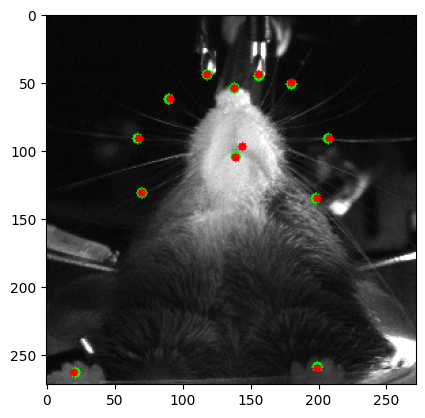

Comparison between ground truth (green) and predictions (red) for img: 
labeled-data/bottom_face_1-0000/img0039.png


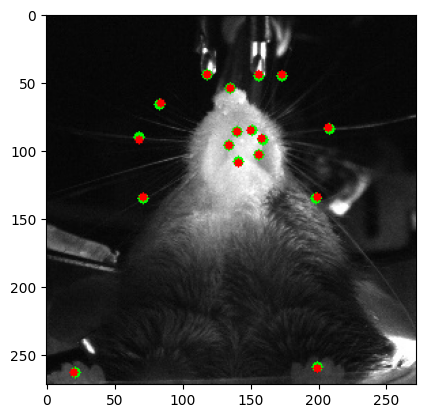

Comparison between ground truth (green) and predictions (red) for img: 
labeled-data/bottom_face_101-0000/img0812.png


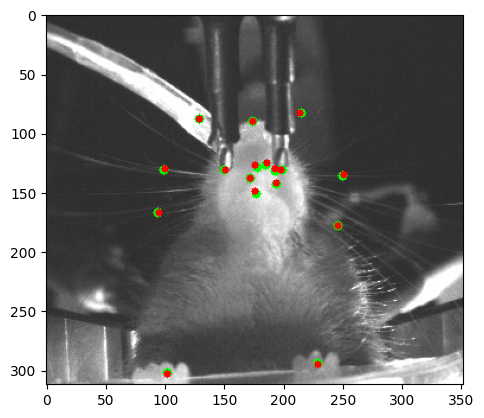

Comparison between ground truth (green) and predictions (red) for img: 
labeled-data/bottom_face_115-0000/img1225.png


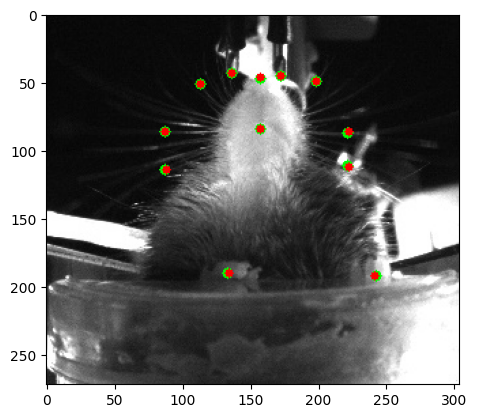

In [22]:
# ----------------------------------------------------------------------------------
# visualize the predictions and ground truth
# ----------------------------------------------------------------------------------
# select the images to visualize
select_imgs = [1, 11, 30, 100] # index 1 points to a training image; 
                      # index 11 points to a testing image.
                      # The last column [“set”] in the predictions_pixel_error.csv file indicates 
# visualize 
for index in select_imgs:
    assert index < n_frames
    
    img_path = gt_df.index[index]
    print(f"Comparison between ground truth (green) and predictions (red) for img: \n{img_path}")
    img = cv2.imread(os.path.join(cfg.data.data_dir, img_path))

    # show ground truth in green, bigger dots
    img = add_marker(img, xarr_gt, yarr_gt, mask_array, index, dotsize=4, color=(0, 255, 0))
    # show prediction in red, smaller dots
    img = add_marker(img, xarr_pr, yarr_pr, mask_array, index, dotsize=3, color=(255, 0, 0))

    plt.imshow(img) 
    plt.show()

# Plot video predictions and unsupervised losses

Plot temporal norm loss, PCA loss, xy coordinates, and confidence of prediction of the testing video

### Load data

In [23]:
from collections import defaultdict
import pandas as pd
from pathlib import Path

from lightning_pose.apps.utils import build_precomputed_metrics_df, get_col_names, concat_dfs
from lightning_pose.apps.utils import update_vid_metric_files_list
from lightning_pose.apps.utils import get_model_folders, get_model_folders_vis
from lightning_pose.apps.plots import plot_precomputed_traces

def get_model_folders_vis_v1(model_folders):
    """Get the last one level of the path """
    fs = []
    for f in model_folders:
        fs.append(f.split("/")[-1:])
    model_folders_vis = [os.path.join(*f) for f in fs]
    return model_folders_vis

# select which model(s) to use
model_folders = [LP_output_dir]
print(f"model_folders: {model_folders}")

# get the last one levels of each path to be presented to user
model_names = get_model_folders_vis_v1(model_folders)
# model_names = [""]
print(f"model_names: {model_names}")

# select the testing video
# ensure we have already made predictions on the selected testing video
curr_video = "bottom_face_101-0000"
# curr_video = "1044385384_524761_20200819.face"
# curr_video = "1128520325_585326_20210915.face.subclip0_30"
print(f"Current testing video: {curr_video}")

# get prediction files for each model
prediction_files = update_vid_metric_files_list(video=curr_video, 
                                                model_preds_folders=model_folders)

model_folders: ['/root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/outputs']
model_names: ['outputs']
Current testing video: bottom_face_101-0000


In [24]:
prediction_files

[[PosixPath('bottom_face_101-0000_temporal_norm.csv'),
  PosixPath('bottom_face_101-0000_pca_singleview_error.csv'),
  PosixPath('bottom_face_101-0000.csv')]]

In [25]:
# load data - temporal norm loss, PCA loss, xy coordinates, confidence of prediction
dframes_metrics = defaultdict(dict)
dframes_traces = {}
for p, model_pred_files in enumerate(prediction_files):
    model_name = model_names[p]
    model_folder = model_folders[p]
    for model_pred_file in model_pred_files:
        model_pred_file_path = os.path.join(model_folder, "video_preds", model_pred_file)
        if not isinstance(model_pred_file, Path):
            model_pred_file.seek(0)  # reset buffer after reading
        if "pca" in str(model_pred_file) or "temporal" in str(model_pred_file) or "pixel" in str(model_pred_file):
            dframe = pd.read_csv(model_pred_file_path, index_col=None)
            dframes_metrics[model_name][str(model_pred_file)] = dframe
        else:
            dframe = pd.read_csv(model_pred_file_path, header=[1, 2], index_col=0)
            dframes_traces[model_name] = dframe
            dframes_metrics[model_name]["confidence"] = dframe
        data_types = dframe.iloc[:, -1].unique()

# compute metrics
# concat dataframes, collapsing hierarchy and making df fatter.
df_concat, keypoint_names = concat_dfs(dframes_traces)
df_metrics = build_precomputed_metrics_df(
    dframes=dframes_metrics, keypoint_names=keypoint_names)
metric_options = list(df_metrics.keys())

# print keypoint names; select one of these to plot below
print(keypoint_names)

# NOTE: you can ignore all errors and warnings of the type:
#    No runtime found, using MemoryCacheStorageManager

['tongueTip', 'tongueLeftFront', 'tongueRightFront', 'tongueLeftBack', 'tongueRightBack', 'LickportLeft', 'LickportRight', 'nosetip', 'jaw', 'pawL', 'pawR', 'WLup', 'WLmid', 'WLbot', 'WRup', 'WRmid', 'WRbot']


In [26]:
metric_options

['temporal norm', 'pca singleview', 'confidence']

### Plot video traces

In [27]:
# rerun this cell each time you want to update the keypoint

from IPython.display import display, clear_output
import ipywidgets as widgets

def on_change(change):
    if change["type"] == "change" and change["name"] == "value":
        clear_output()
        cols = get_col_names(change["new"], "x", dframes_metrics.keys())
        fig_traces = plot_precomputed_traces(df_metrics, df_concat, cols)
        fig_traces.show()

# create a Dropdown widget
dropdown = widgets.Dropdown(
    options=keypoint_names,
    value=None,  # Set the default selected value
    description="Select keypoint:",
)

# update plot upon change
dropdown.observe(on_change)

# display widget
display(dropdown)

Dropdown(description='Select keypoint:', options=('tongueTip', 'tongueLeftFront', 'tongueRightFront', 'tongueL…

# Perform comparison between two models
Compare the trained model in litpose_training_Part1 with another pretrained model
* [Load a trained model and run prediction](#Load-a-trained-model-and-run-prediction)
* [Compute mean pixel error](#Compute-mean-pixel-error)

In [19]:
import csv
def compute_mean_error(
    error_files: List[str], 
    alg_names: List[str], 
    out_file: str) -> None:
    """Compute mean pixel error per bodypart
    
    Args:
        error_files: list of the frame-wise pixel error .csv files
        alg_names: list of the model names corresponding to error_files
        out_file: path to save the results
    
    Return:
        save results to .csv file
    """
    assert len(error_files) == len(alg_names), f"The length of error files ({len(error_files)}) is NOT equal to the length of algorithms {len(alg_names)}!"
    assert len(error_files) > 0, f"The error files NOT exist!"
    
    # get keypoint names
    df = pd.read_csv(error_files[0])
    keypoint_names = list(df.columns[1:-1])
    print(f"\nkeypoint_names: {keypoint_names}, {len(keypoint_names)}")

    with open(out_file, 'a') as f:
        fieldnames = ['Algorithm'] + keypoint_names + ['Average']
        write = csv.writer(f) 
        write.writerows([fieldnames]) 
    res = []
    for cur_file, alg_name in zip(error_files, alg_names):
        print(f"\nWorking on {alg_name} ......")
        print(f"Loading {cur_file}")
        
        df = pd.read_csv(cur_file)
        temp_list = []
        temp_list.append(alg_name)

        # compute mean pixel error per bodypart
        for col in df.columns[1:-1]:
            mean  = float(format(np.nanmean(df[col].astype("float"), axis=0), '.3f'))
            stdev = float(format(np.nanstd(df[col].astype("float"), axis=0), '.3f'))
            temp_list.append("{:.2f} ± {:.2f}".format(mean, stdev))
        
        # compute mean pixel error averaged over all keypoints
        df = df.iloc[: , 1:-1]
        mean  = float(format(np.nanmean(df.astype("float")), '.3f'))
        stdev = float(format(np.nanstd(df.astype("float")), '.3f'))
        temp_list.append("{:.2f} ± {:.2f}".format(mean, stdev))
        print("Average error: {:.2f} ± {:.2f} pixel".format(mean, stdev))
        res.append(temp_list)
    
    # save the table to out_file
    with open(out_file, 'a') as f:
        write = csv.writer(f) 
        write.writerows(res)

### Load a trained model and run prediction

In [30]:
# ----------------------------------------------------------------------------------
# perform prediction using a model trained with 29 videos and epoch=389
# ----------------------------------------------------------------------------------
curr_ckpt = "/root/capsule/code/models/Han_behavior_data/Foraging_Bot-Han_Lucas-2022-04-27/epoch=389-step=23010.ckpt"

# path to save results
LP_output_dir_epoch389 = os.path.join(LP_data_dir, "outputs_epoch389")
Path(LP_output_dir_epoch389).mkdir(parents=True, exist_ok=True)
print(f"\nCurrent ckpt file: {curr_ckpt}")
print(f"LP output directory: {LP_output_dir_epoch389}")

# make predictions on the labeled frames and testing videos using curr_ckpt
subclip_video_flag = False
predict_imgs_and_videos_in_dir(cfg, 
                               curr_ckpt, 
                               LP_output_dir_epoch389,
                               subclip_video_flag)



Current ckpt file: /root/capsule/code/models/Han_behavior_data/Foraging_Bot-Han_Lucas-2022-04-27/epoch=389-step=23010.ckpt
LP output directory: /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/outputs_epoch389

Loading the pretrained model: /root/capsule/code/models/Han_behavior_data/Foraging_Bot-Han_Lucas-2022-04-27/epoch=389-step=23010.ckpt
using default image augmentation pipeline (resizing only)
Number of labeled images in the full dataset (train+val+test): 156
Size of -- train set: 124, val set: 15, test set: 17
-----------------------------------
Predicting train/val/test images...
-----------------------------------

 Initializing a HeatmapTracker instance.


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.0MB/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Results of running PCA (pca_singleview) on keypoints:
Kept 7/24 components, and found:
Explained variance ratio: [0.506 0.34  0.086 0.024 0.016 0.011 0.008 0.003 0.002 0.001 0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
Variance explained by 7 components: 0.991
--------------------
Predicting videos...
--------------------
---------------------------------------------------------------------------------------------------------------------------------------
Found 10 videos to predict on /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/videos/
---------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Predicting video: /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Duration of video [s]: 42, recorded at 30.0 fps!
Moviepy - Building video /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/outputs_epoch389/video_preds/labeled_videos/bottom_face_101-0000_labeled.mp4.
Moviepy - Writing video /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/outputs_epoch389/video_preds/labeled_videos/bottom_face_101-0000_labeled.mp4



Moviepy - Done !
Moviepy - video ready /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/outputs_epoch389/video_preds/labeled_videos/bottom_face_101-0000_labeled.mp4
Results of running PCA (pca_singleview) on keypoints:
Kept 7/24 components, and found:
Explained variance ratio: [0.506 0.34  0.086 0.024 0.016 0.011 0.008 0.003 0.002 0.001 0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
Variance explained by 7 components: 0.991


### Compute mean pixel error
Compute the mean pixel error averaged over each body part and all keypoints

In [31]:
# ----------------------------------------------------------------------------------
# Compute evaluation metrics: mean pixel error
# ----------------------------------------------------------------------------------
print(f"Comparing the trained model \n**{curr_ckpt}** \nto the model trained in Part1 \n**{ckpt_file}**")
print("\nCompute the mean pixel error averaged over each body part and all keypoints...")

# path to save reuslts
out_file = os.path.join(LP_output_dir, 'model_compare_pixel_error_average.csv')
if os.path.exists(out_file):
    os.remove(out_file)
print(f"\nSave average pixel error to {out_file}")

# directly compare the trained ckpt in litpose_training_Part1 with the model trained with epoch=389
# Load pixel-wise pixel error .csv files
pixel_error_files = [
    os.path.join(LP_output_dir, "predictions_pixel_error.csv"),
    os.path.join(LP_output_dir_epoch389, "predictions_pixel_error.csv")
    ]

# get the epoch of the trained model in litpose_training_Part1
epoch = ckpt_file.split("/")[-1].split("-")[0].split("=")[-1]

# set the model names that generates the pixel_error_files
alg_names = [f"LP_epoch{epoch}", 
             "LP_epoch389"]

# Run
compute_mean_error(pixel_error_files, 
                   alg_names, 
                   out_file)


# ----------------------------------------------------------------------------------
# print table
# ----------------------------------------------------------------------------------
df = pd.read_csv(out_file)
df

Comparing the trained model 
**/root/capsule/code/models/Han_behavior_data/Foraging_Bot-Han_Lucas-2022-04-27/epoch=389-step=23010.ckpt** 
to the model trained in Part1 
**/root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/outputs/tb_logs/test/version_0/checkpoints/epoch=189-step=1520.ckpt**

Compute the mean pixel error averaged over each body part and all keypoints...

Save average pixel error to /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/outputs/model_compare_pixel_error_average.csv

keypoint_names: ['tongueTip', 'tongueLeftFront', 'tongueRightFront', 'tongueLeftBack', 'tongueRightBack', 'LickportLeft', 'LickportRight', 'nosetip', 'jaw', 'pawL', 'pawR', 'WLup', 'WLmid', 'WLbot', 'WRup', 'WRmid', 'WRbot'], 17

Working on LP_epoch189 ......
Loading /root/capsule/scratch/DLC_dataset_for_LP/Han_behavior_data_test/Foraging_Bot-Han_Lucas-2022-04-27/outputs/predictions_pixel_error.csv
Avera

,Algorithm,tongueTip,tongueLeftFront,tongueRightFront,tongueLeftBack,tongueRightBack,LickportLeft,LickportRight,nosetip,jaw,pawL,pawR,WLup,WLmid,WLbot,WRup,WRmid,WRbot,Average
0,LP_epoch189,0.85 ± 0.62,0.94 ± 0.88,1.03 ± 1.11,0.63 ± 0.47,1.27 ± 4.59,0.49 ± 0.34,0.61 ± 0.49,0.53 ± 0.38,0.87 ± 1.10,0.94 ± 0.92,0.63 ± 0.52,0.97 ± 0.78,0.86 ± 1.17,0.95 ± 1.08,1.03 ± 1.46,0.87 ± 1.31,0.85 ± 1.41,0.83 ± 1.28
1,LP_epoch389,0.54 ± 0.44,0.61 ± 0.44,0.59 ± 0.43,0.61 ± 0.47,0.59 ± 0.52,0.38 ± 0.24,0.46 ± 0.32,0.47 ± 0.27,0.48 ± 0.36,0.88 ± 0.78,0.52 ± 0.58,0.65 ± 0.86,0.68 ± 0.92,0.72 ± 1.42,0.62 ± 0.81,0.73 ± 0.94,0.56 ± 1.18,0.59 ± 0.77
